# EMG Data Exploration

In this notebook we explore the sEMG dataset for different hand gestures. We perform the following steps:

* Preprocess and clean up our dataset
* Leverage signal processing to smooth out the dataset
* Perform a variety of classification techniques

In [7]:
import random

import numpy as np
import pandas as pd

import scipy.io
import scipy
from scipy import signal

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.cluster import KMeans

In [8]:
""" Define schema of datasets
"""

DATABASE = {
    'Database 1': ['female_1',
                  'female_2',
                  'female_3',
                  'male_1',
                  'male_2'],
    'Database 2': ['male_day_1',
                  'male_day_2',
                  'male_day_3']
}

COLUMNS = ['cyl_ch1', 
            'cyl_ch2', 
            'hook_ch1', 
            'hook_ch2', 
            'tip_ch1', 
            'tip_ch2', 
            'palm_ch1', 
            'palm_ch2', 
            'spher_ch1', 
            'spher_ch2', 
            'lat_ch1', 
            'lat_ch2']

LABELS = [
    'Spherical',
    'Tip',
    'Palmar',
    'Lateral',
    'Cylindrical',
    'Hook'
]

COL_MAPPINGS = {
            'cyl_ch1': 'Cylindrical', 
            'cyl_ch2': 'Cylindrical', 
            'hook_ch1': 'Hook', 
            'hook_ch2': 'Hook', 
            'tip_ch1': 'Tip', 
            'tip_ch2': 'Tip', 
            'palm_ch1': 'Palmar', 
            'palm_ch2': 'Palmar', 
            'spher_ch1': 'Spherical', 
            'spher_ch2': 'Spherical', 
            'lat_ch1': 'Lateral', 
            'lat_ch2': 'Lateral'
}

In [9]:
""" Preprocess and standardize dataset into a single dataframe table
"""

DB_NAME = 'Database 1'
dfs = []
for fname in DATABASE[DB_NAME]: 
    tmp_data = scipy.io.loadmat(f'./data/{DB_NAME}/{fname}')
    tmp_data = {k:v for k,v in tmp_data.items() if k in COLUMNS}
    for c in COLUMNS:
        tmp_dfx = pd.DataFrame(tmp_data[c])
        tmp_dfx['identifier'] = fname
        tmp_dfx['label'] = COL_MAPPINGS[c]
        dfs.append(pd.DataFrame(tmp_dfx))

dataset = pd.concat(dfs)
print("Dimensions", dataset.shape)
dataset.head()

Dimensions (1800, 3002)


,0,1,2,3,4,5,6,7,8,9,...,2992,2993,2994,2995,2996,2997,2998,2999,identifier,label
0,0.072198,0.276211,0.429221,0.327214,0.123201,0.097700,0.072198,0.021195,-0.004307,0.174205,...,0.276211,-0.259323,0.072198,1.882814,0.480224,-2.528968,0.097700,0.837247,female_1,Cylindrical
1,0.250710,0.301713,0.199706,0.378218,0.021195,-0.080812,-0.106313,0.021195,0.276211,0.072198,...,-1.304890,0.786244,0.786244,0.939254,1.270775,-0.616346,0.454723,0.021195,female_1,Cylindrical
2,0.123201,0.148703,0.148703,0.123201,-0.004307,-0.157317,-0.029808,0.174205,0.199706,0.250710,...,-0.233821,0.403719,0.046696,-0.080812,0.378218,-0.361330,0.505726,0.607732,female_1,Cylindrical
3,0.531228,-0.106313,-0.284825,-0.335828,-0.182818,0.123201,0.301713,0.352716,0.327214,-0.029808,...,0.709739,0.276211,-0.080812,0.123201,0.735241,1.270775,-0.769356,-1.687415,female_1,Cylindrical
4,-0.310326,-0.182818,0.276211,0.480224,0.352716,0.123201,0.123201,0.097700,-0.029808,-0.080812,...,-0.208320,0.429221,0.378218,0.633234,0.811746,0.403719,-0.182818,-0.412333,female_1,Cylindrical


In [10]:
#combine coupled readouts
new_dfs = []
for lab in LABELS:
    new_temp = dataset[dataset['label'] == lab].values
    new_temp_comb = pd.DataFrame(np.concatenate((new_temp[:150,:3000],new_temp[150:,:3002]),axis=1))
    new_dfs.append(new_temp_comb)
    


new_dataset = pd.concat(new_dfs)
new_dataset.rename(columns={6001:'label', 6000:'identifier'}, inplace=True)

In [11]:
dx = scipy.io.loadmat('./data/Database 2/male_day_1.mat')
dx.keys()

dict_keys(['__header__', '__version__', '__globals__', 'cyl_ch1', 'cyl_ch2', 'hook_ch1', 'hook_ch2', 'tip_ch1', 'tip_ch2', 'palm_ch1', 'palm_ch2', 'spher_ch1', 'spher_ch2', 'lat_ch1', 'lat_ch2'])

In [12]:
""" Apply absolute value filter to set all values >0
"""
##emg_abs = abs(hook_df)
#plt.plot((emg_abs.to_numpy()[5,:]))

' Apply absolute value filter to set all values >0\n'

In [13]:
def abs_val_filter(data):
    """ Apply an absolute value filter to a DataFrame
    """
    return abs(data.copy())

def butterworth_low_pass_filter(data, 
                                frequency=500, 
                                lp_filter=5,
                                order=4):
    """
    Create a low pass filter to eliminate noise and smooth EMG data 
    
    The data were collected at a sampling rate of 500 Hz, 
    using as a programming kernel the National Instruments (NI) Labview. 
    The signals were band-pass filtered using a Butterworth Band Pass filter 
    with low and high cutoff at 15Hz and 500Hz respectively and a notch filter at 50Hz 
    to eliminate line interference artifacts.
    """
    lp_filter = lp_filter/(frequency/2)

    # Create a lowpass butterworth signal 
    B, A = scipy.signal.butter(order, 
                               lp_filter, 
                               btype='lowpass')

    # Apply the lowpass signal filter to EMG data
    smooth_emg = scipy.signal.filtfilt(B, 
                                       A, 
                                       data)
    return smooth_emg


def holt_smoothing(data,
                  s_level = 0.5,
                  s_slope = 0.1):
    smoothed = Holt(data[0]).fit(smoothing_level=s_level, smoothing_slope=s_slope).fittedvalues[:]
    print(data[0])
    print(smoothed)
    return smoothed

In [14]:
new_dataset.columns

Index([           0,            1,            2,            3,            4,
                  5,            6,            7,            8,            9,
       ...
               5992,         5993,         5994,         5995,         5996,
               5997,         5998,         5999, 'identifier',      'label'],
      dtype='object', length=6002)

In [15]:
df_features = new_dataset.iloc[:,:6000].copy()
df_labels = new_dataset.iloc[:, 6001]
df_features = abs_val_filter(df_features)

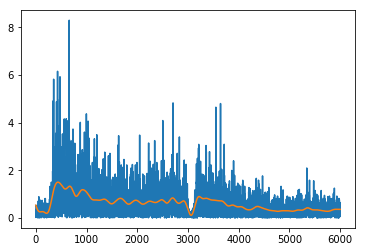

In [16]:
smoothed_emg_df = butterworth_low_pass_filter(df_features.to_numpy(),
                                             frequency=5000,
                                             lp_filter=25)
plt.plot(df_features.to_numpy()[0])
plt.plot(smoothed_emg_df[0])

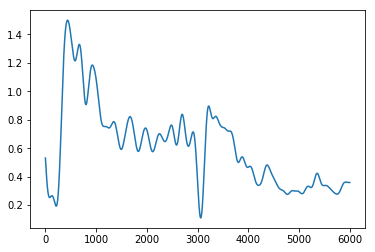

In [17]:
plt.plot(smoothed_emg_df[0])

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(smoothed_emg_df.T)
transformed = pca.components_.T

In [19]:
""" Split EMG dataset into training and testing
"""

X_train, X_test, y_train, y_test = train_test_split(transformed, 
                                                    df_labels, 
                                                    test_size=0.2, 
                                                    random_state=12)

In [20]:
""" SVM Classification Results
"""

clf = make_pipeline(StandardScaler(),
                    SVC(gamma='auto', 
                        degree=2,
                       kernel='rbf'))
clf.fit(X_train, y_train)

svm_labels = clf.predict(X_test)

(svm_labels == y_test).value_counts()/len(X_test)

True     0.522222
False    0.477778
Name: label, dtype: float64

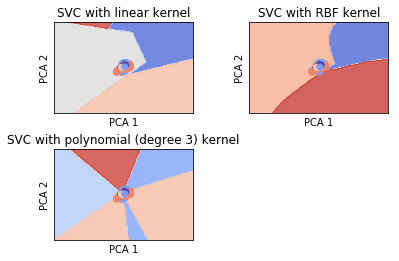

In [22]:
# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train_alt = le.transform(y_train)
h = .02 

svc = SVC(kernel='linear', C=C).fit(X_train, y_train_alt)
rbf_svc = SVC(kernel='rbf', gamma=0.7, C=C).fit(X_train, y_train_alt)
poly_svc = SVC(kernel='poly', degree=3, C=C).fit(X_train, y_train_alt)

# create a mesh to plot in
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']


for i, clf in enumerate((svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train_alt, cmap=plt.cm.coolwarm)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()

In [117]:
""" KMeans unsupervised learning
"""

kmeans = KMeans(n_clusters=len(LABELS)).fit(X_train)

kmeans.labels_
predicted_labels = kmeans.predict(X_test)
predicted_labels

1 - (sum([abs(i[0] - i[1]) for i in zip(sorted(np.bincount(le.transform(y_test))), 
                                   sorted(np.bincount(predicted_labels)))])/len(y_test))

0.4666666666666667

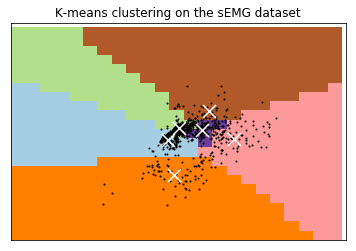

In [82]:
""" Code taken from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html
"""

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

reduced_data = transformed

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1

x_min /= 5
x_max /= 5
y_min /= 5
y_max /= 5

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the sEMG dataset')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [116]:
""" GM Classification Results
"""
import math
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=6).fit(X_train)
labels = gmm.predict(X_test)
1 - (sum([abs(i[0] - i[1]) for i in zip(sorted(np.bincount(le.transform(y_test))), 
                                   sorted(np.bincount(labels)))])/len(y_test))

0.5888888888888889

In [104]:
dict(zip(sorted(np.bincount(le.transform(y_test))), 
                                   sorted(np.bincount(labels))))

{24: 7, 25: 13, 31: 23, 32: 42, 36: 57}

In [84]:
""" NB Classification Rules
"""

from sklearn.naive_bayes import GaussianNB

gnb = make_pipeline(StandardScaler(),
                    GaussianNB())
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
print("Accuracy", (y_test != y_pred).sum() / X_test.shape[0])

Number of mislabeled points out of a total 180 points : 96
Accuracy 0.5333333333333333
